<a href="https://colab.research.google.com/github/DanieloSendi/Deep-Learning-Lab/blob/main/11_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time Series**

## Introduction

Until now, the only sequence data we’ve covered have been text data, such as the IMDB dataset and the Reuters dataset. But sequence data is found in many more problems than just language processing. You will now use weather time-series dataset recorded at the Weather Station at the Max Planck Institute for Biogeochemistry in Jena, Germany. We will carefully go through an example presented by F. Chollet in his book Deep Learning with Python and compare how different types of networks solve the time-series prediction problem.

## Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

## Download data

In this dataset, 14 different quantities (such as air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes, over several years. The original data goes back to 2003, but this example is limited to data from 2009–2016. This dataset is perfect for learning to work with numerical time-series. You’ll use it to build a model that takes as input some data from the recent past (a few days’ worths of data points) and predicts the air temperature 24 hours in the future.

Download data from https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip.

Extract data to one of your directories, load them and check if they are correct.

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

!unzip jena_climate_2009_2016.csv.zip

--2024-12-17 13:09:36--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.165.240, 52.216.217.72, 52.216.57.168, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.165.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  2.44MB/s    in 12s     

2024-12-17 13:09:49 (1.09 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [ ]:
text_file = open('jena_climate_2009_2016.csv', 'r')

data = text_file.read()
text_file.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


The exact formulation of the problem will be as follows: given data going as far back as `lookback` timesteps (a timestep is 10 minutes) and sampled every `steps` timesteps, can you predict the temperature in `delay` timesteps? You’ll use the following parameter values:

- lookback = 720 — Observations will go back 5 days.
- steps = 6 — Observations will be sampled at one data point per hour.
- delay = 144 — Targets will be 24 hours in the future.

## Explore dataset

To get started, you need to do two things:

- Preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so you don’t need to do any vectorization. But each timeseries in the data is on a different scale (for example, the temperature is typically between -20 and +30, but atmospheric pressure, measured in mbar, is around 1,000). You’ll normalize each timeseries independently so that they all take small values on a similar scale.
- Write a Python generator that takes the current array of float data and yields batches of data from the recent past, along with a target temperature in the future. Because the samples in the dataset are highly redundant (sample N and sample N + 1 will have most of their timesteps in common), it would be wasteful to explicitly allocate every sample. Instead, you’ll generate the samples on the fly using the original data. You’ll preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation. You’re going to use the first 200,000 timesteps as training data, so compute the mean and standard deviation only on this fraction of the data.

First, parse the data:

In [ ]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
print(float_data.shape)

(420451, 14)


As we are interested only in the temperature, extract it from the whole set of 14 variables. To understand the problem better you can plot the whole series or some specific parts of it:

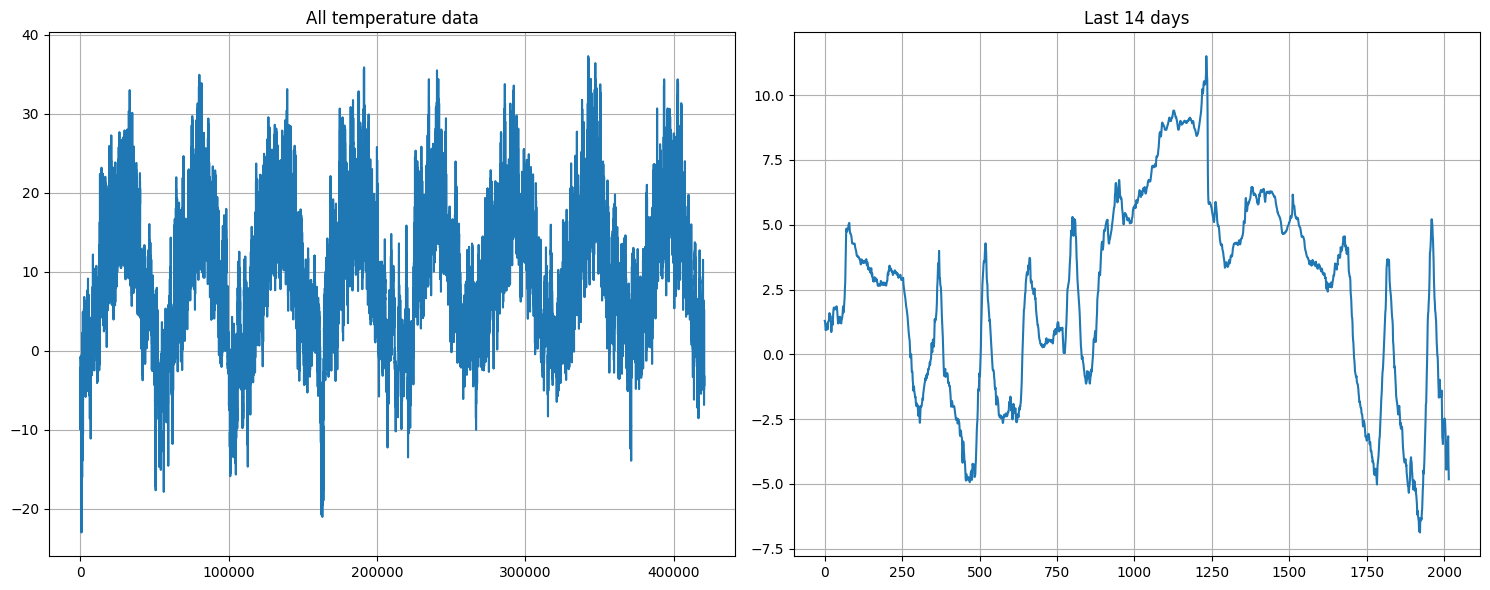

In [ ]:
temp = float_data[:, 1]

# Plot whole temperature series, notice yearly trends
plt.figure(figsize=(15, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(temp)
plt.title("All temperature data")
plt.grid()

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(temp[-(6*24*14):])
plt.title("Last 14 days")
plt.grid()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


Normalize the data by subtracting the mean and dividing by the standard deviation (calculated on a train set (first 200000 samples)):

In [ ]:
#Normalize the data
float_data_mean = np.mean(float_data, axis=0)
float_data_std = np.std(float_data[:20000, :], axis=0)

float_data = (float_data - float_data_mean) / float_data_std

The normalization should be done for all 14 variables independently, not only for temperature. We predict only one parameter (target - y), but analyse all of them (input - x).

## Set up data generators function

Now, let’s use the abstract generator function to instantiate three generators: one for training, one for validation, and one for testing. Each will look at different temporal segments of the original data: the training generator looks at the first 200,000 timesteps, the validation generator looks at the following 100,000, and the test generator looks at the remainder.

In [ ]:
# generator function used to feed the training, validation and test data
def generator(data, lookback, delay, min_index, max_index,
                shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                    min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

Let's now define `lookback`, `step`, `delay` parameters and set generators. In the example, `batch_size = 128` was used, but you can try with different values.

In [ ]:
# Define lookback, step, delay and batch size variable
lookback = 720
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=0,
                        max_index=200000,
                        shuffle=True,
                        step=step,
                        batch_size=batch_size)

#Set a validation generator similar to train generator. Use next 100000 samples (max index from 200,000 to 300,000). Do not shuftle the data:
val_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=200000,
                        max_index=300000,
                        shuffle=False,
                        step=step,
                        batch_size=batch_size)

#Set a validation generator similar to a train generator. Use further next 100000 samples (max index from 300,000 onwards). Do not shuffle the data:
test_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=300000,
                        max_index=400000,
                        shuffle=False,
                        step=step,
                        batch_size=batch_size)


## Network training

Useful info:

- You should expect a loss value in range 0,2-0,4 for both training and validation. 0,4 is quite bad. 0,3 is ok. 0,2 on a training set means overfitting, on validation it will be almost impossible to get.
- You should expect a huge overfitting. Some results won't be good at all - validation will not improve in some cases.
- The best results will probably come from a GRU layers with added dropout.
- The fastest training should be achieved with conv1D

- Make sure to set a `steps_per_epoch` and `validation_step` parameters. Some keras functions like ImageDataGenerator allow for skipping this parameter and set it automatically. However, in this task we have our own generator which will run indefinitely if we do not stop it.
- Make sure to normalize the data for each variable, not only for a temperature.
- Make sure to shuffle data only in a train generator.
- In some cases specifying a batch_size twice (in a generator and in `model.fit`) might cause an error.
- You should not see any regular oscilations in the validation loss. Such behaviour on the loss plot indicates some errors. Possibly with `steps_per_epoch` parameter.

## Basic approach - standard network with flatten and dense layers
We will start with a basic approach that uses no recurrent layers. It probably won't work well, but will serve as a reference point. The following section shows a fully connected model that starts by flattening the data and then runs it through two Dense layers. Note the lack of activation function on the last Dense layer, which is typical for a regression problem. You use MAE as the loss.

In [ ]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

# Number of steps to draw from val_gen to see the entire validation set
# val_steps = (300000 - 200001 - lookback)//batch_size

# Number of steps to draw from val_gen to see the entire validation set
val_steps = (300000 - 200001 - lookback) // (batch_size*step)
steps_per_epoch=200000//(batch_size*step)

# Train the network for about 20 epochs
history = model.fit(train_gen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=20,
                    batch_size=128,
                    validation_data=val_gen,
                    validation_steps=val_steps)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.4017 - val_loss: 0.5513
Epoch 2/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.5719 - val_loss: 0.3559
Epoch 3/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.3953 - val_loss: 0.3100
Epoch 4/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3471 - val_loss: 0.3533
Epoch 5/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3330 - val_loss: 0.3560
Epoch 6/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3228 - val_loss: 0.3275
Epoch 7/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3138 - val_loss: 0.3586
Epoch 8/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.3075 - val_loss: 0.3343
Epoch 9/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3012 - val_loss: 0.3407
Epoch 10/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3004 - val_loss: 0.3484
Epoch 11/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2968 - val_loss: 0.3441
Epoch 12/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/s

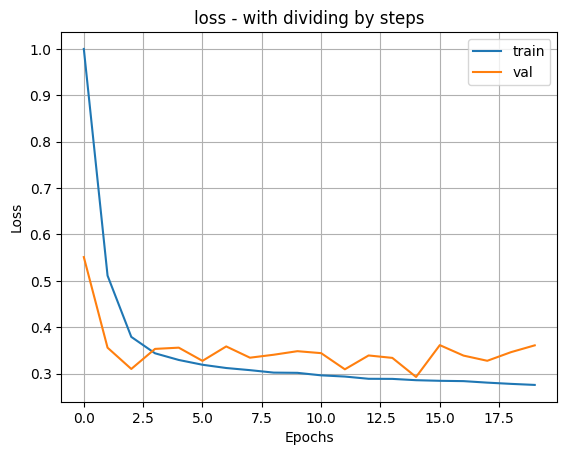

In [ ]:
history_dict = history.history
history_dict.keys()

# Extract values from the training history
training_loss = history_dict['loss']
validation_loss = history_dict['val_loss']

# Plot training and validation loss
plt.figure(2)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('loss - with dividing by steps')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.grid()
plt.show()

In [ ]:
test_steps = (400000 - 300001 - lookback)//(batch_size*step)
predicted_data = model.predict(test_gen, batch_size=batch_size, steps=test_steps)

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


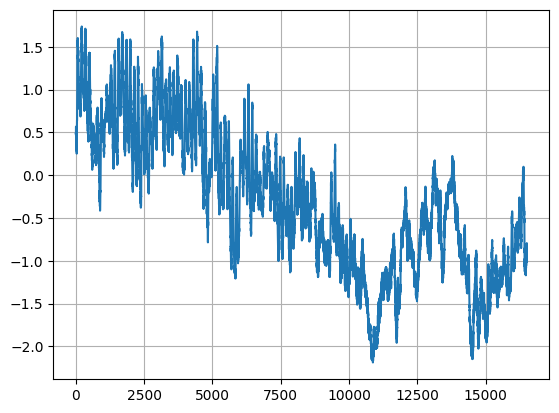

In [ ]:
plt.figure()
plt.plot(predicted_data)
plt.grid()
plt.show()

## GRU layer

Instead of the LSTM layer introduced in the previous lab, you’ll use the GRU layer, [developed by Chung et al. in 2014](https://arxiv.org/abs/1412.3555). Gated recurrent unit (GRU) layers work using the same principle as LSTM, but they’re somewhat streamlined and thus cheaper to run (although they may not have as much representational power as LSTM).

In [ ]:
model2 = Sequential()
model2.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model2.add(layers.Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Train this network for about 20 epochs and plot the results.

In [ ]:
model2.compile(optimizer=RMSprop(), loss='mae')

# Number of steps to draw from val_gen to see the entire validation set
val_steps = (300000 - 200001 - lookback)// (batch_size*step)
steps_per_epoch = 200000//(batch_size*step)

history2 = model2.fit(train_gen,
                      steps_per_epoch=steps_per_epoch,
                      epochs=20,
                      batch_size=128,
                      validation_data=val_gen,
                      validation_steps=val_steps)

Epoch 1/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.5424 - val_loss: 0.3105
Epoch 2/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.3405 - val_loss: 0.3202
Epoch 3/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.3318 - val_loss: 0.3407
Epoch 4/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.3289 - val_loss: 0.2929
Epoch 5/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.3245 - val_loss: 0.2691
Epoch 6/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.3229 - val_loss: 0.3082
Epoch 7/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.3160 - val_loss: 0.2899
Epoch 8/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.3216 - val_loss: 0.3148
Epoch 9/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.3108 - val_loss: 0.3397
Epoch 10/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.3157 - val_loss: 0.2863
Epoch 11/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.3057 - val_loss: 0.2711
Epoch 12/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 

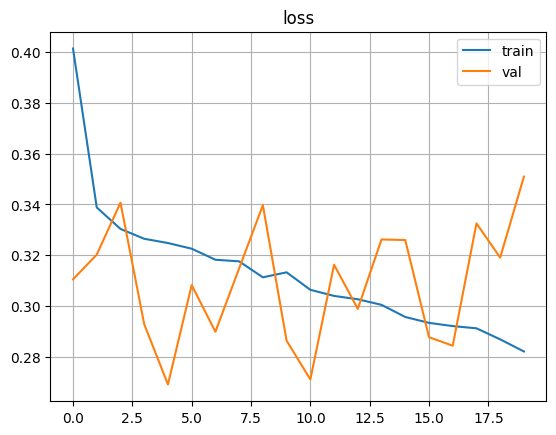

In [ ]:
history_dict2 = history2.history
history_dict2.keys()

plt.figure(2)
plt.plot(history_dict2['loss'])
plt.plot(history_dict2['val_loss'])
plt.title('loss')
plt.legend(['train', 'val'])
plt.grid()

plt.show()

## GRU layer with dropout and recurrent dropout

You can also try stacking several GRU layers on each other, or adding dropout and recurrent dropout to the GRU layer. In this case train it a bit longer (aboout 40 epochs)

In [ ]:
model3 = Sequential()
model3.add(layers.GRU(32,dropout=0.2,recurrent_dropout=0.2,input_shape=(None, float_data.shape[-1])))
model3.add(layers.Dense(1))

model3.compile(optimizer=RMSprop(), loss='mae')

# Number of steps to draw from val_gen to see the entire validation set
val_steps = (300000 - 200001 - lookback)// (batch_size*step)
steps_per_epoch = 200000//(batch_size*step)

history3 = model3.fit(train_gen,
                      steps_per_epoch=steps_per_epoch,
                      epochs=40,
                      batch_size=128,
                      validation_data=val_gen,
                      validation_steps=val_steps)

Epoch 1/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 70s 257ms/step - loss: 86105504.0000 - val_loss: 0.7588
Epoch 2/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 64s 246ms/step - loss: 569213.0625 - val_loss: 0.9937
Epoch 3/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 68s 261ms/step - loss: 62955.4570 - val_loss: 1.2969
Epoch 4/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 65s 251ms/step - loss: 13623.6270 - val_loss: 0.9441
Epoch 5/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 66s 254ms/step - loss: 4979.7515 - val_loss: 0.8074
Epoch 6/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 65s 249ms/step - loss: 55279.2852 - val_loss: 0.8639
Epoch 7/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 65s 250ms/step - loss: 2520.5049 - val_loss: 0.6692
Epoch 8/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 65s 250ms/step - loss: 6789.2109 - val_loss: 0.8267
Epoch 9/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 65s 248ms/step - loss: 4651.6504 - val_loss: 1.0089
Epoch 10/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 66s 254ms/step - loss: 344.5128 - val_loss: 0.4133
Epoch 11/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 65s 249ms/step - loss: 13470.1

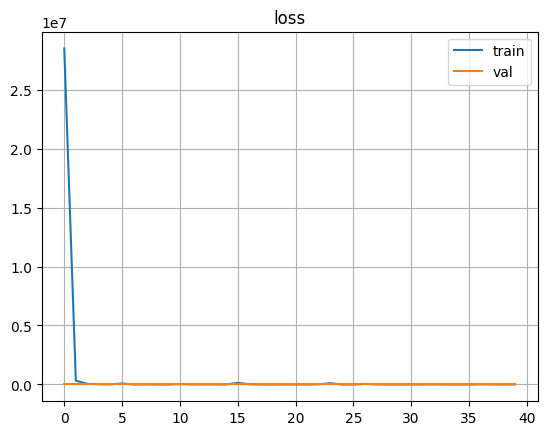

In [ ]:
history_dict3 = history3.history
history_dict3.keys()

plt.figure(2)
plt.plot(history_dict3['loss'])
plt.plot(history_dict3['val_loss'])
plt.title('loss')
plt.legend(['train', 'val'])
plt.grid()

plt.show()

## Bidirectional GRU layer

A bidirectional recurrent neural network exploits the order sensitivity of RNNs: it consists of using two regular RNNs, such as the GRU and LSTM layers you’re already familiar with, each of which processes the input sequence in one direction (chronologically and antichronologically), and then merging their representations. By processing a sequence both ways, a bidirectional RNN can catch patterns that may be overlooked by a unidirectional RNN.

Try training bidirectional GRU for about 40 epochs, but don't expect much improvement vs simple GRU. In this example reversing data order does not carry much information, but keep in mind that this is possible and might sometimes be useful.

In [ ]:
model4 = Sequential()
model4.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model4.add(layers.Dense(1))

model4.compile(optimizer=RMSprop(), loss='mae')

# Number of steps to draw from val_gen to see the entire validation set
val_steps = (300000 - 200001 - lookback)// (batch_size*step)
steps_per_epoch = 200000//(batch_size*step)

history4 = model4.fit(train_gen,
                      steps_per_epoch=steps_per_epoch,
                      epochs=40,
                      batch_size=128,
                      validation_data=val_gen,
                      validation_steps=val_steps)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.4005 - val_loss: 0.3154
Epoch 2/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.3320 - val_loss: 0.3009
Epoch 3/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.3260 - val_loss: 0.3530
Epoch 4/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.3211 - val_loss: 0.2913
Epoch 5/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.3122 - val_loss: 0.3033
Epoch 6/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.3106 - val_loss: 0.3183
Epoch 7/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.3079 - val_loss: 0.3190
Epoch 8/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.3060 - val_loss: 0.3074
Epoch 9/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.3019 - val_loss: 0.3497
Epoch 10/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.2978 - val_loss: 0.2908
Epoch 11/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.2979 - val_loss: 0.2823
Epoch 12/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/ste

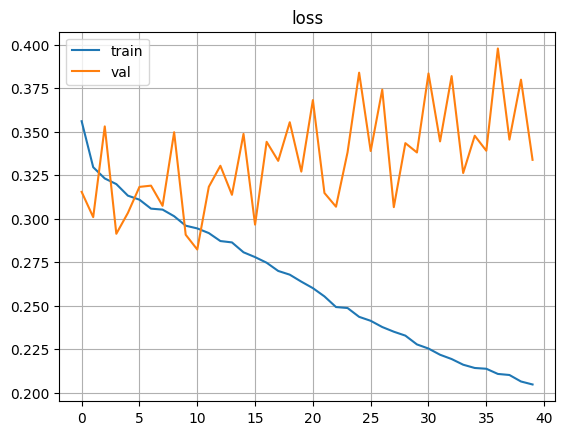

In [ ]:
history_dict4 = history4.history
history_dict4.keys()

plt.figure(2)
plt.plot(history_dict4['loss'])
plt.plot(history_dict4['val_loss'])
plt.title('loss')
plt.legend(['train', 'val'])
plt.grid()

plt.show()

## Conv1D layers

ConvNets, we worked on before, extracted local features and allow for representation modularity. The same properties that make them excel at computer vision also make them highly relevant to sequence processing. They can be competitive with RNNs on certain sequence-processing problems, usually at a considerably cheaper computational cost.

2D convolution layers extract patches from image tensors and apply an identical transformation to every patch. In the same way, you can use 1D convolutions, extracting local 1D patches (subsequences) from sequences. Because the same input transformation is performed on every patch, a pattern learned at a certain position in a sentence can later be recognized in a different position.

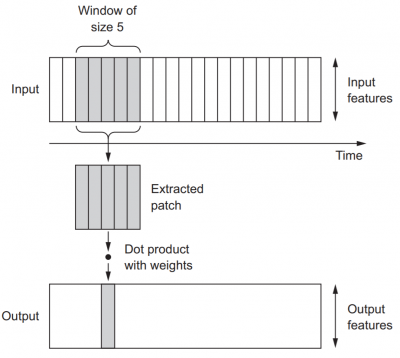

In [ ]:
model5 = Sequential()
model5.add(layers.Input(shape=(None, float_data.shape[-1])))
model5.add(layers.Conv1D(32, 5, activation='relu'))

model5.add(layers.MaxPooling1D(3))
model5.add(layers.Conv1D(32, 5, activation='relu'))
model5.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.2))
model5.add(layers.Dense(1))

This lab was based on the book Deep Learning with Python by F.Chollet. Fragments of the code (with some modifications) are available also in the [this Notebook](https://www.kaggle.com/code/pankrzysiu/6-3-1-a-temperature-forecasting-problem/notebook), [Tensorflow Website](https://www.tensorflow.org/tutorials/structured_data/time_series), or [Keras Website](https://keras.io/examples/timeseries/timeseries_weather_forecasting/).

In [ ]:
model5.compile(optimizer=RMSprop(), loss='mae')

# Number of steps to draw from val_gen to see the entire validation set
val_steps = (300000 - 200001 - lookback) // (batch_size*step)
steps_per_epoch = 200000//(batch_size*step)

In [ ]:
history5 = model5.fit(train_gen,
                      steps_per_epoch=steps_per_epoch,
                      epochs=40,
                      batch_size=128,
                      validation_data=val_gen,
                      validation_steps=val_steps)

Epoch 1/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 29s 104ms/step - loss: 0.5475 - val_loss: 0.4125
Epoch 2/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step - loss: 0.3876 - val_loss: 0.3182
Epoch 3/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - loss: 0.3703 - val_loss: 0.2838
Epoch 4/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - loss: 0.3579 - val_loss: 0.3476
Epoch 5/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - loss: 0.3500 - val_loss: 0.3330
Epoch 6/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - loss: 0.3447 - val_loss: 0.3301
Epoch 7/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 24s 93ms/step - loss: 0.3454 - val_loss: 0.3587
Epoch 8/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 95ms/step - loss: 0.3394 - val_loss: 0.3052
Epoch 9/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 96ms/step - loss: 0.3326 - val_loss: 0.2884
Epoch 10/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - loss: 0.3284 - val_loss: 0.3442
Epoch 11/40
260/260 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step - loss: 0.3293 - val_loss: 0.3328
Epoch 12/40
260/260 ━━━━━━━━━

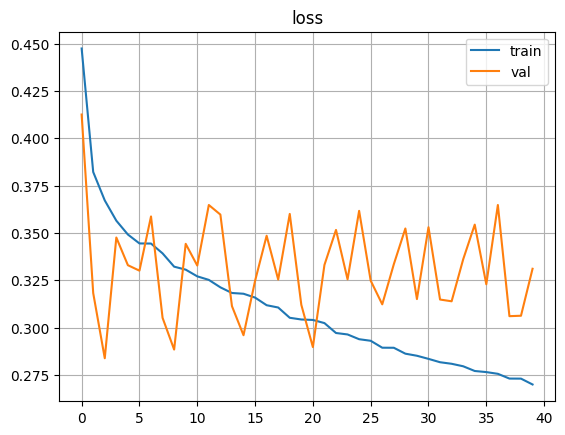

In [ ]:
history_dict5 = history5.history
history_dict5.keys()

plt.figure(2)
plt.plot(history_dict5['loss'])
plt.plot(history_dict5['val_loss'])
plt.title('loss')
plt.legend(['train', 'val'])
plt.grid()

plt.show()

The GRU network without dropout achieved the best results.  

In the case of the GRU network without dropout, there was a phenomenon similar to overfitting - the loss value for the validation set fluctuated while for the training set the error still had a uniform downward trend. Adding dropout to the GRU layer or using a bidirectional network did not noticeably affect the results.  

All solutions except the classical approach are characterised by some periodicity of the loss values for the validation set and some overfitting.